In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import pandas as pd

from src.utils import visualize_batch
from src.dataset import OxfordPetCustom
from src.models import ClassificationModel
from torch.utils.data import DataLoader, random_split

## Dataset

In [2]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

device = "cuda"

transform_train = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomCrop(128, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [3]:
dataset = OxfordPetCustom("data/oxford-iiit-pet/images", transform_train)

total_size = len(dataset)
train_size = int(0.7 * total_size)  # 80% for training
val_size = int(0.15 * total_size)  # 10% for validation
test_size = total_size - train_size - val_size  # Remaining for testing

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size]
)


In [4]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

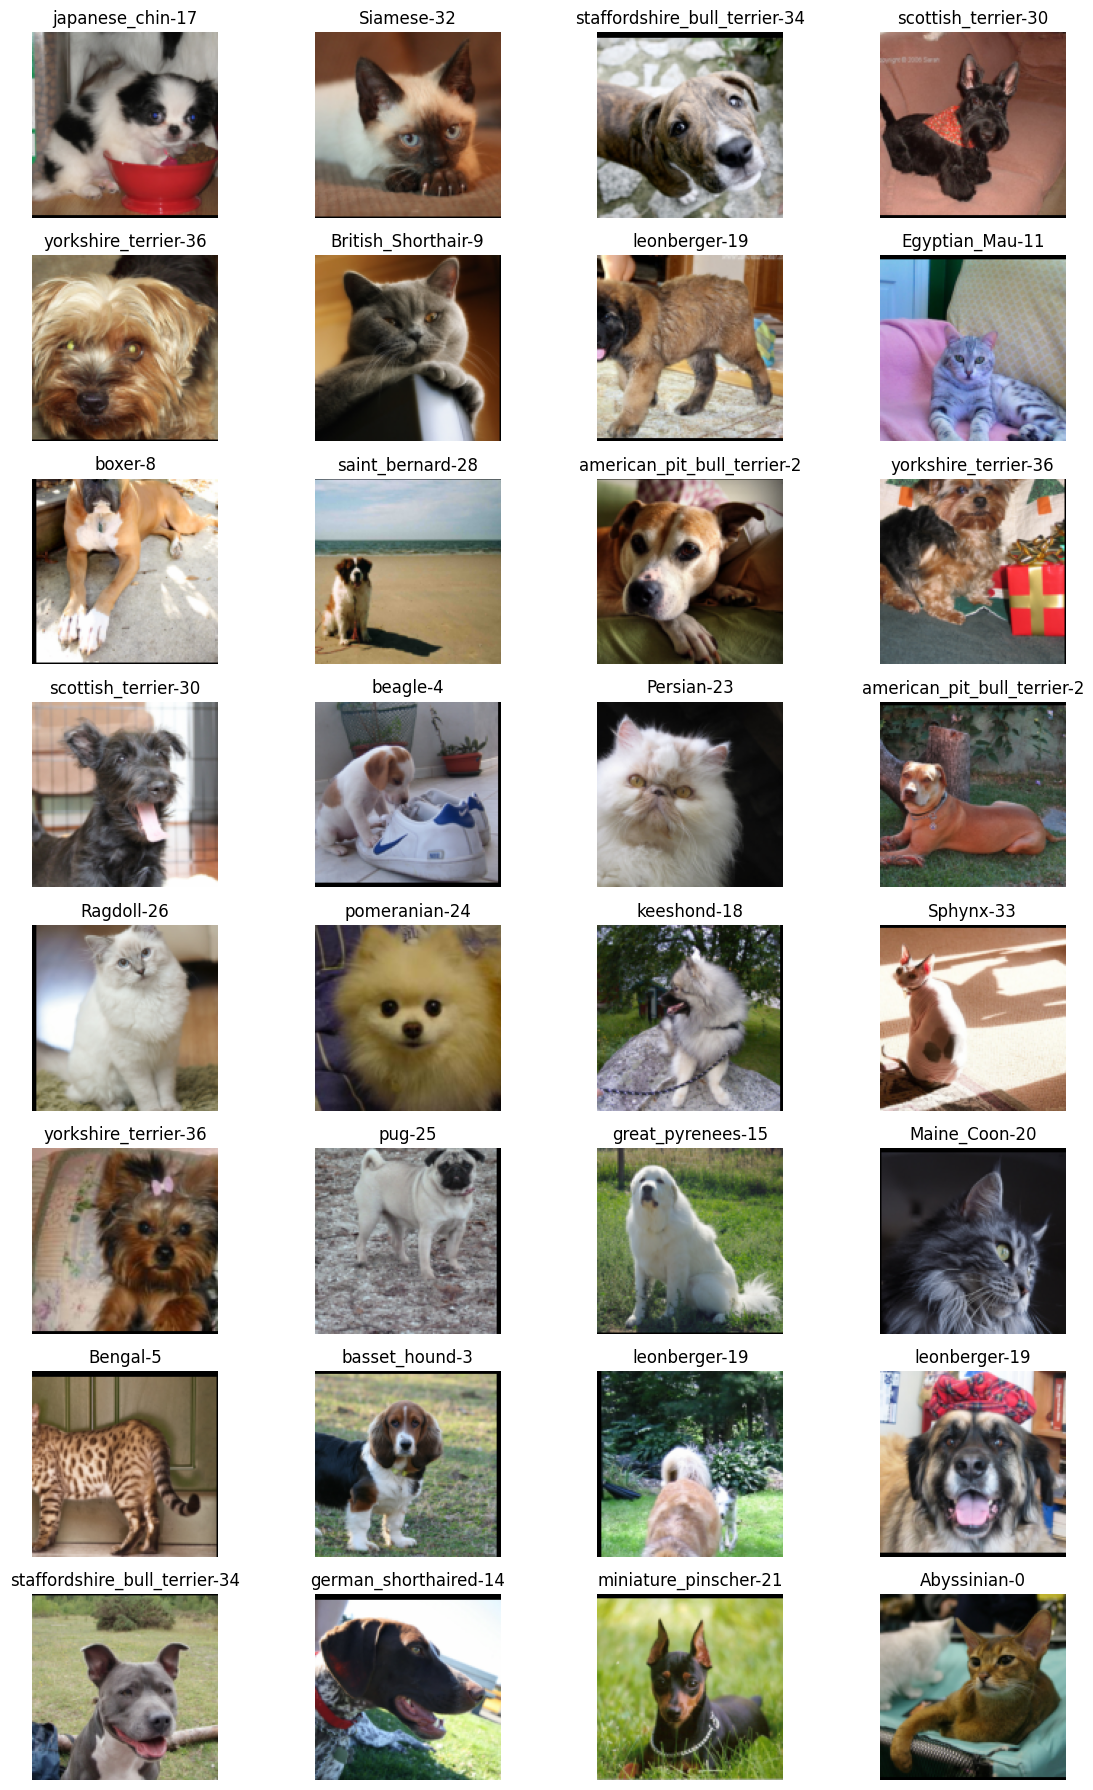

In [5]:
for batch in enumerate(train_loader):
    visualize_batch(batch)
    break

## KNN

In [21]:
backbone = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights)
model = ClassificationModel(backbone, mode = "encoder").to(device)    ##out_dim = (2048,)

/home/avishka/anaconda3/envs/wm/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
embeddings = []
true_labels = []

for batch in enumerate(train_loader):
    _, (imgs, labels) = batch
    imgs = imgs.to(device)
    emb = model(imgs).detach().cpu()
    embeddings += emb
    true_labels += labels

In [29]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=37)
neigh.fit(embeddings, true_labels)

KNeighborsClassifier(n_neighbors=37)

In [30]:
for batch in enumerate(val_loader):
    i, (imgs, labels) = batch
    imgs = imgs.to(device)
    emb = model(imgs).detach().cpu()
    break

In [31]:
yhat = neigh.predict(emb)
yhat

array([13, 25,  9, 18, 16, 35, 12,  5,  7, 33, 25,  7, 22, 15, 19,  5, 32,
       17, 24, 22,  3, 27, 17, 19,  5, 32, 32,  7,  3, 17, 11, 29])

In [33]:
labels

tensor([13, 25,  9, 18, 16, 12, 12, 21,  7, 13, 25,  7, 22, 24, 19,  5, 32, 17,
        24, 22,  3,  9, 17, 19,  5, 32,  6,  7,  3, 17, 11, 24])

## Finetune projection head only

In [6]:
backbone = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights)
model = ClassificationModel(backbone, mode="enc_dec").to(device)

/home/avishka/anaconda3/envs/wm/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [8]:
epochs = 10
for epoch in range(epochs):
    model.train()
    for batch in enumerate(train_loader):
        _, (imgs, labels) = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    scheduler.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in enumerate(val_loader):
            _, (imgs, labels) = batch
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Epoch [1/10], Loss: 1.5995
Validation Accuracy: 73.65%
Epoch [2/10], Loss: 1.3305
Validation Accuracy: 78.07%
Epoch [3/10], Loss: 1.1114
Validation Accuracy: 79.42%
Epoch [4/10], Loss: 1.0672
Validation Accuracy: 80.14%
Epoch [5/10], Loss: 0.9810
Validation Accuracy: 78.97%
Epoch [6/10], Loss: 1.1182
Validation Accuracy: 79.96%
Epoch [7/10], Loss: 0.6711
Validation Accuracy: 79.78%
Epoch [8/10], Loss: 0.5372
Validation Accuracy: 81.41%
Epoch [9/10], Loss: 1.0334
Validation Accuracy: 81.05%
Epoch [10/10], Loss: 0.3742
Validation Accuracy: 82.13%


## Finetune full model

In [9]:
backbone = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights)
model = ClassificationModel(backbone, mode="enc_dec_full").to(device)

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

In [11]:
epochs = 10
for epoch in range(epochs):
    model.train()
    for batch in enumerate(train_loader):
        _, (imgs, labels) = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    scheduler.step()

    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for batch in enumerate(val_loader):
            _, (imgs, labels) = batch
            imgs = imgs.to(device)
            labels = labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Epoch [1/10], Loss: 0.7361
Validation Accuracy: 82.04%
Epoch [2/10], Loss: 0.5817
Validation Accuracy: 84.39%
Epoch [3/10], Loss: 0.3372
Validation Accuracy: 83.57%
Epoch [4/10], Loss: 0.2826
Validation Accuracy: 85.83%
Epoch [5/10], Loss: 0.0596
Validation Accuracy: 86.82%
Epoch [6/10], Loss: 0.2073
Validation Accuracy: 88.72%
Epoch [7/10], Loss: 0.1642
Validation Accuracy: 88.90%
Epoch [8/10], Loss: 0.1097
Validation Accuracy: 88.54%
Epoch [9/10], Loss: 0.2957
Validation Accuracy: 88.81%
Epoch [10/10], Loss: 0.0214
Validation Accuracy: 90.25%
